In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import sys
sys.path.append("../../")
from src.mps import mps
from src.mps import tebd
from src.tdvp import tdvp
from src.mps import tfi_model
from src.mps import mps_runge_kutta

In this notebook we will compare the time evolution of the two-site Time Dependent Variational Principle (TDVP) method with standard Time Evolving Block Decimation (TEBD), using the transverse field ising model (TFI) as an example.

In [4]:
def overlap(bra, ket):
    L = len(bra.Bs)
    assert(L == len(ket.Bs))
    left = np.ones(1)
    left = np.reshape(left, (1, 1))
    for n in range(L):
        # Contract left with bra
        left = np.tensordot(left, bra.Bs[n].conj(), (0, 0))
        # Contract left with ket
        left = np.tensordot(left, ket.Bs[n], [(0, 1), (0, 1)])
    return left[0, 0]

In [6]:
L = 14

In [7]:
MPS_all_spin_up = mps.MPS.initialize_spinup(L)

In [8]:
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]])
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]])

In [9]:
J = 1.
g = 1.5
chi_max = 100
eps = 1.e-10
t_stop = 10*J

# TEBD

In [13]:
dts_TEBD = [0.1]
ms_TEBD = [[] for i in range(len(dts_TEBD))]

model = tfi_model.TFIModel(L, J, g)

for i, dt in enumerate(dts_TEBD):
    start = time.time()
    print("computing for dt =", dt)
    N = (int)(np.ceil(t_stop/dt))
    U_bonds = tebd.calc_U_bonds(model, dt*1.j) # imagingary t for real time evolution!
    psi = MPS_all_spin_up.copy()
    for _ in range(N):
        tebd.run_TEBD(psi, U_bonds, N_steps=1, chi_max=chi_max, eps=eps)
        ms_TEBD[i].append(np.real_if_close(np.sum(psi.site_expectation_value(sigma_z))))
    end = time.time()
    print("took", end-start, "seconds!")

computing for dt = 0.1
took 1.2979061603546143 seconds!


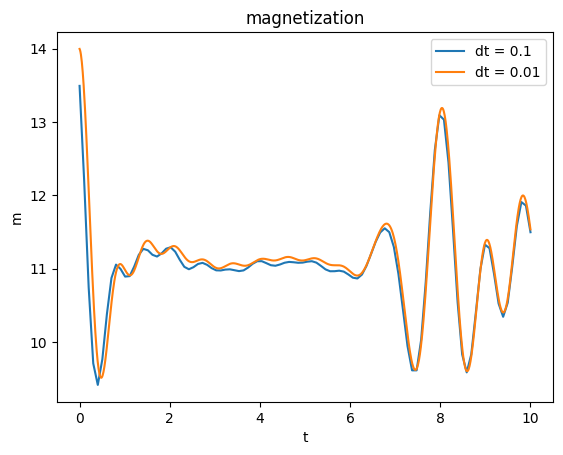

In [10]:
for i, dt in enumerate(dts_TEBD):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_TEBD[i], label="dt = "+str(dt))
plt.legend()
plt.title("magnetization")
plt.ylabel("m")
plt.xlabel("t")
plt.show()

# TDVP2

In [35]:
dts_TDVP_2 = [0.1]

ms_TDVP_2 = [[] for i in range(len(dts_TDVP_2))]
print(L, J, g)
model = tfi_model.TFIModel(L, J, g)

chi_max = 20
eps = 1.e-10
average_bond_dimensions_TDVP_2 = []

for i, dt in enumerate(dts_TDVP_2):
    print("computing for dt =", dt)
    N = (int)(np.ceil(t_stop/dt))
    psi = MPS_all_spin_up.copy()
    average_bond_dimensions_TDVP_2.append(psi.get_average_bond_dim())
    engine = tdvp.TDVP2_Engine(psi, model, dt, chi_max, eps)
    start = time.time()
    for _ in tqdm(range(N)):
        engine.sweep()
        ms_TDVP_2[i].append(np.real_if_close(np.sum(engine.psi.site_expectation_value(sigma_z))))
        average_bond_dimensions_TDVP_2.append(psi.get_average_bond_dim())
    end = time.time()
    print("took", end-start, "seconds")

14 1.0 1.5
computing for dt = 0.1
Length:  14


  0%|          | 0/100 [00:00<?, ?it/s]

took 213.5585174560547 seconds


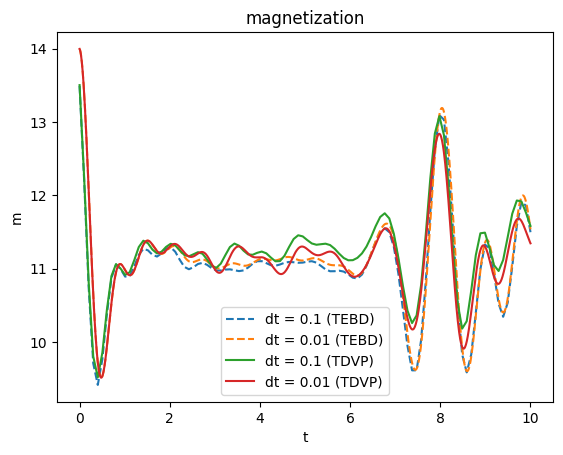

In [12]:
for i, dt in enumerate(dts_TEBD):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_TEBD[i], "--", label="dt = "+str(dt)+" (TEBD)")
for i, dt in enumerate(dts_TDVP_2):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_TDVP_2[i], label="dt = "+str(dt)+" (TDVP)")
plt.legend()
plt.title("magnetization")
plt.ylabel("m")
plt.xlabel("t")
plt.show()

TDVP achieves roughly the same results as TEBD, but is roughly 20 times slower.
The advantage of course is that TDVP works with MPOS and can therefore also describe long-range interactions in contrast to TEBD which can only describe nearest-neighbour interactions.

# TDVP1 (fixed bond dimension)

In [33]:
dts_TDVP_1 = [0.1]

ms_TDVP_1 = [[] for i in range(len(dts_TDVP_1))]

model = tfi_model.TFIModel(L, J, g)

chi_max = 20
eps = 1.e-10
average_bond_dimensions_TDVP_1 = []

for i, dt in enumerate(dts_TDVP_1):
    print("computing for dt =", dt)
    N = (int)(np.ceil(t_stop/dt))
    psi = mps.MPS.initialize_spinup(L, chimax=chi_max)
    average_bond_dimensions_TDVP_1.append(psi.get_average_bond_dim())
    engine = tdvp.TDVP1_Engine(psi, model, dt)
    start = time.time()
    for _ in tqdm(range(N)):
        engine.sweep()
        ms_TDVP_1[i].append(np.real_if_close(np.sum(engine.psi.site_expectation_value(sigma_z))))
        average_bond_dimensions_TDVP_1.append(psi.get_average_bond_dim())
    end = time.time()
    print("took", end-start, "seconds")

computing for dt = 0.1
Length:  14


  0%|          | 0/100 [00:00<?, ?it/s]

took 67.12261199951172 seconds


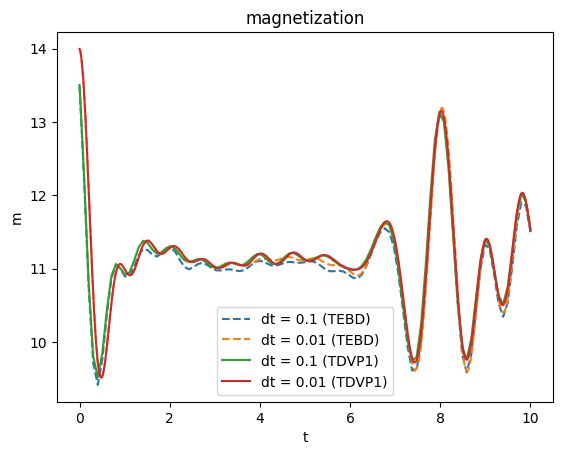

In [85]:
for i, dt in enumerate(dts_TEBD):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_TEBD[i], "--", label="dt = "+str(dt)+" (TEBD)")
for i, dt in enumerate(dts_TDVP_1):
    N = (int)(np.ceil(t_stop/dt))
    ts = np.linspace(0, t_stop, N)
    plt.plot(ts, ms_TDVP_1[i], label="dt = "+str(dt)+" (TDVP1)")
plt.legend()
plt.title("magnetization")
plt.ylabel("m")
plt.xlabel("t")
plt.show()

# CBE-TDVP 

In [32]:
dts_TDVP_CBE = [0.1]

ms_TDVP_CBE = [[] for i in range(len(dts_TDVP_CBE))]

model = tfi_model.TFIModel(L, J, g)
chi_max = 20
eps = 1.e-10
average_bond_dimensions_TDVP_CBE = []

for i, dt in enumerate(dts_TDVP_CBE):
    print("computing for dt =", dt)
    N = (int)(np.ceil(t_stop/dt))
    psi = MPS_all_spin_up.copy()
    average_bond_dimensions_TDVP_CBE.append(psi.get_average_bond_dim())
    engine = tdvp.CBETDVP_Engine(psi, model, dt, D_max=20)
    start = time.time()
    for _ in tqdm(range(N)):
        engine.sweep()
        ms_TDVP_CBE[i].append(np.real_if_close(np.sum(engine.psi.site_expectation_value(sigma_z))))
        average_bond_dimensions_TDVP_CBE.append(psi.get_average_bond_dim())
    end = time.time()
    print("took", end-start, "seconds")


computing for dt = 0.1
Length:  14
1e-10


  0%|          | 0/100 [00:00<?, ?it/s]

Health check of preselected A: 0.0
Health check of preselected A: 0.0
Health check of preselected A: 0.0
Health check of preselected A: 0.0
Health check of preselected A: 0.0
Health check of preselected A: 0.0
Health check of preselected A: 0.0
Health check of preselected A: 0.0
Health check of preselected A: 0.0
Health check of preselected A: 0.0
Health check of preselected A: 0.0
Health check of preselected A: 0.0
Health check of preselected A: 0.0
Health check of preselected A: 1.4374007069886996e-14
Health check of preselected A: 3.9558511823790345e-15
Health check of preselected A: 1.906459048104214e-14
Health check of preselected A: 1.400367815119904e-14
Health check of preselected A: 1.4747761603913516e-14
Health check of preselected A: 2.8535310287861626e-14
Health check of preselected A: 7.010406269356892e-15
Health check of preselected A: 1.7971681963737236e-14
Health check of preselected A: 8.616581576336701e-15
Health check of preselected A: 7.890617746928274e-15
Health che

[20.0, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.307692307692308, 12.3076923076

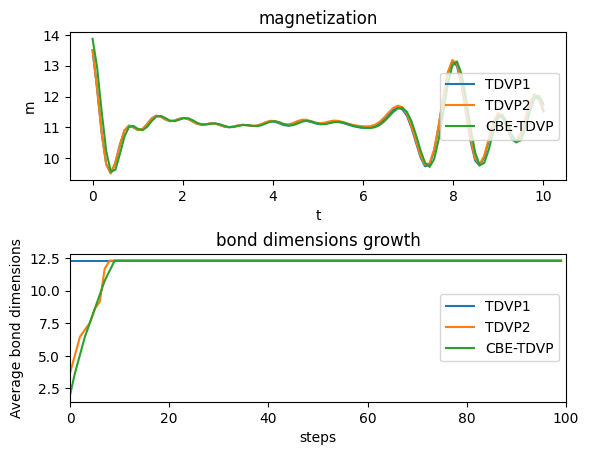

In [36]:
dt = 0.1
i = 0

fig, axs = plt.subplots(2)

# axs[0].plot(np.linspace(0, duration, N_steps), sigma_zs_2, "-", label="2TDVP")
# axs[1].plot(range(0, N_steps), average_bond_dimensions_2, "-", label="2TDVP")
# axs[0].legend(loc="center right")
# axs[1].legend(loc="center right")
# axs[0].set_ylim(-1, 1)
# axs[0].set_xlim(0, duration)    
# axs[1].set_xlim(0, N_steps)
# axs[0].set_xlabel("Time")
# axs[0].set_ylabel("Expectation value")
# axs[1].set_xlabel("Steps")
# axs[1].set_ylabel("Bond dimensions")
# noise_title = "with noise" if use_noise else "without noise"
# fig.suptitle(f'Comparison between 2TDVP and CBE-TDVP\nwith g={g[0]} {noise_title}') 
# fig.subplots_adjust(hspace=0.3)

N = (int)(np.ceil(t_stop/dt))
ts = np.linspace(0, t_stop, N)
axs[0].plot(ts, ms_TDVP_1[i], "-", label="TDVP1")
axs[1].plot(range(N), average_bond_dimensions_TDVP_1[1:], "-", label="TDVP1")

axs[0].plot(ts, ms_TDVP_2[i], "-", label="TDVP2")
axs[1].plot(range(N), average_bond_dimensions_TDVP_2[1:], "-", label="TDVP2")

axs[0].plot(ts, ms_TDVP_CBE[i], "-", label="CBE-TDVP")
axs[1].plot(range(N), average_bond_dimensions_TDVP_CBE[1:], "-", label="CBE-TDVP")

axs[0].legend(loc="center right")
axs[0].set_title("magnetization")
axs[0].set_ylabel("m")
axs[0].set_xlabel("t")
axs[1].legend(loc="center right")
axs[1].set_title("bond dimensions growth")
axs[1].set_ylabel("Average bond dimensions")
axs[1].set_xlabel("steps")
axs[1].set_xlim(0, N)
fig.subplots_adjust(hspace=0.5)
print(average_bond_dimensions_TDVP_1)
print(average_bond_dimensions_TDVP_2)
print(average_bond_dimensions_TDVP_CBE)